# <center> **CLIM 680 Assignment** </center>

```
The following notebook makes use of Soil Moisture Active Passive (SMAP) Level 4 (L4) data which consists of the assimilation of raw or corrected measurements into a land surface model to produce geophysical parameters. Data files from 20210627 are obtained from the Center for Ocean-Land-Atmosphere Studies' remote server, though they are publicly available through NASA-designated data centers. The file contains information pertaining to the heat flux, soil moisture, and surface state variables at the stated time. This dataset was chosen because it is relevant to my research.
```

## Table of Contents

---
* [Imports](#Imports)
* [Assignment One](#AOne)
    * [Data Info and Access](#DataAc1)
    * [Filled Contour](#Contour)
    * [Filled Contour Map](#Map)
* [Assignment Two](#ATwo)
    * [Multi-File Access](#DataAc2)
    * [Data Aggregation](#Groupby)
    * [Climatology](#Clim)
        * [Net Radiation Flux](#NetRad)
        * [Latent Heat Flux](#LHF)
        * [Sensible Heat Flux](#SHF)
        * [Ground Heat Flux](#GHF)
* [Assignment Three](#AThree)
    * [Composite Data](#Comp)
    
---

## Imports<a class="anchor" id="Imports"></a>

In [1]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

import glob
import calendar
from datetime import datetime
from dateutil.relativedelta import relativedelta
from shapely.geometry.polygon import LinearRing
import matplotlib.patches as mpatches

In [2]:
#import sys
#!conda install -c conda-forge --yes --prefix {sys.prefix} h5netcdf

In [3]:
#xr.__version__

## Assignment One<a class="anchor" id="AOne"></a>

### Data Info & Access<a class="anchor" id="DataAc1"></a>

In [12]:
file = "/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_20210627.nc4"
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:                            (x: 3856, y: 1624)
Coordinates:
  * x                                  (x) float64 -1.736e+07 ... 1.736e+07
  * y                                  (y) float64 7.31e+06 ... -7.31e+06
Data variables:
    EASE2_global_projection            |S1 ...
    cell_column                        (y, x) float64 ...
    cell_lat                           (y, x) float32 ...
    cell_lon                           (y, x) float32 ...
    cell_row                           (y, x) float64 ...
    time                               datetime64[ns] ...
    baseflow_flux                      (y, x) float32 ...
    heat_flux_ground                   (y, x) float32 ...
    heat_flux_latent                   (y, x) float32 ...
    heat_flux_sensible                 (y, x) float32 ...
    height_lowatmmodlay                (y, x) float32 ...
    land_evapotranspiration_flux       (y, x) float32 ...
    land_fraction_saturated            (y, x) float32 ...
   

### Filled Contour<a class="anchor" id="Contour"></a>

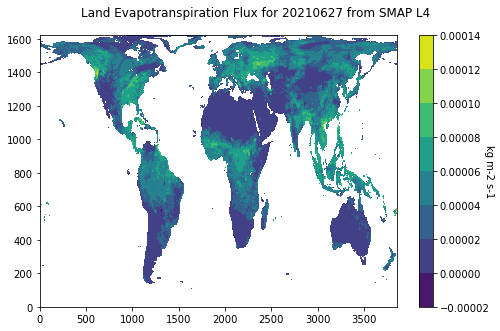

In [32]:
fig = plt.figure(figsize=(8,5))
plt.contourf(ds["land_evapotranspiration_flux"][-1::-1,:]);
cbar = plt.colorbar()
cbar.set_label('kg m-2 s-1', rotation=270)
plt.suptitle("Land Evapotranspiration Flux for 20210627 from SMAP L4", fontsize=12, y=.96)
plt.savefig('Figs/LandEvap_Contour.png')

### Filled Contour Map<a class="anchor" id="Map"></a>

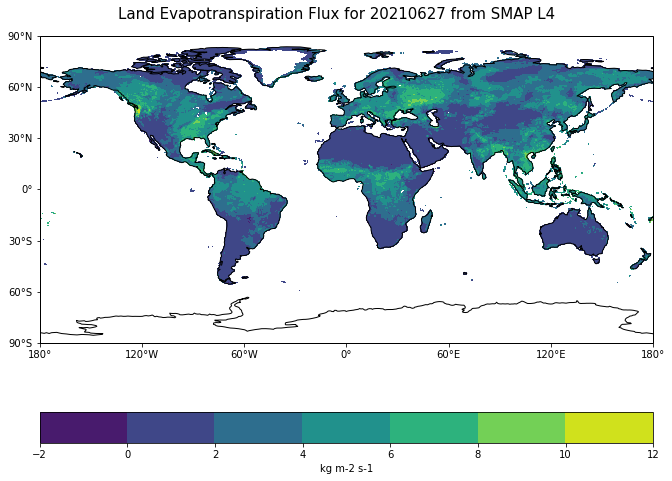

In [33]:
# Set size of image
fig = plt.figure(figsize=(11,8.5))

# Set the axes projection for plot
ax = plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
cs = ax.contourf(ds['cell_lon'], ds['cell_lat'], ds['land_evapotranspiration_flux']*86400, transform = ccrs.PlateCarree())

# Add Coastlines
ax.coastlines()

# Define the xticks for longitude
ax.set_xticks(np.arange(-180,181,60), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Define the yticks for latitude
ax.set_yticks(np.arange(-90,91,30), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

cbar = plt.colorbar(cs, orientation='horizontal', label = 'kg m-2 s-1')
plt.suptitle("Land Evapotranspiration Flux for 20210627 from SMAP L4", fontsize=15, y=.90)
plt.savefig('Figs/LandEvap_CartopyContour.png')

## Assignment Two<a class="anchor" id="ATwo"></a>

### Multi-File Access<a class="anchor" id="DataAc2"></a>

In [12]:
ds2_list = glob.glob("/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_201*.nc4")
#netcdf_list

In [13]:
ds2 = xr.open_mfdataset(paths=ds2_list, combine='nested', concat_dim='time').isel(y=slice(600,120, -1), 
                                                                                  x=slice(540,1280))
ds2

<xarray.Dataset>
Dimensions:                            (time: 1736, x: 740, y: 480)
Coordinates:
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * time                               (time) datetime64[ns] 2016-03-25T01:28:55.816000 ... 2019-08-29T01:28:55.816000
Data variables:
    EASE2_global_projection            (time) |S1 b'' b'' b'' ... b'' b'' b''
    cell_column                        (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (time, y, x) float32 dask.array<chunksize=(1, 48

In [18]:
#Net Radiation variable (SWin-SWout-LWin-LWout)
Rad_da = ds2['net_downward_shortwave_flux'] + ds2['net_downward_longwave_flux']

### Data Aggregation<a class="anchor" id="Groupby"></a>

In [19]:
ds2_climo=ds2.groupby('time.month').mean(dim='time')
ds2_climo

<xarray.Dataset>
Dimensions:                            (month: 12, x: 740, y: 480)
Coordinates:
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * month                              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    cell_column                        (month, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (month, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (month, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    heat_flux_ground                   (month, y, x) float32 dask.array<chunksize=(1, 4

In [20]:
#Create Climatology for Net Radiation
Rad_climo=Rad_da.groupby('time.month').mean(dim='time')

### 12-Panel Climatology<a class="anchor" id="Clim"></a>

#### Net Radiation<a class="anchor" id="NetRad"></a>

KeyboardInterrupt: 

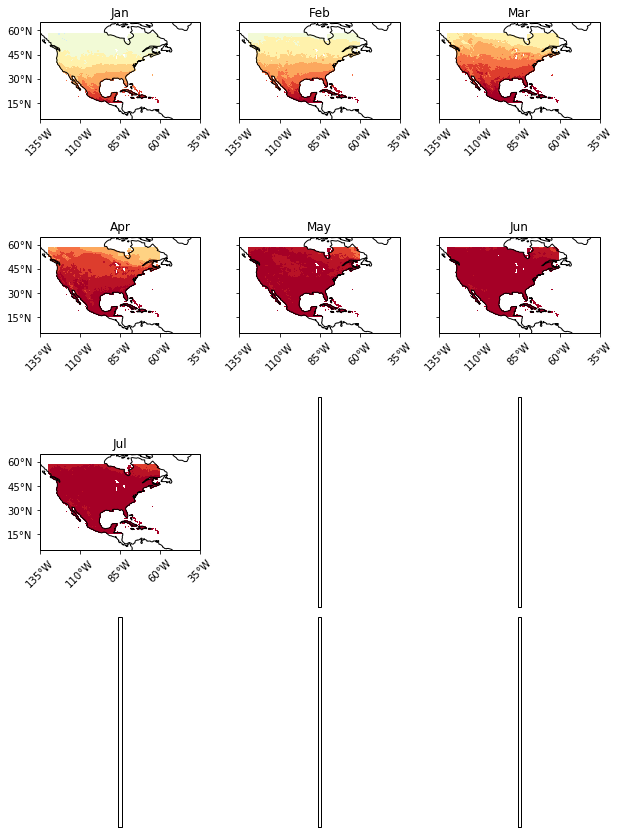

In [26]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
clevs_Rad=np.arange(-30,151,25)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], Rad_climo[i,:,:],
                          clevs_Rad, transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of the Net Radiation ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_NetRad2.png')

#### Latent Heat Flux<a class="anchor" id="LHF"></a>

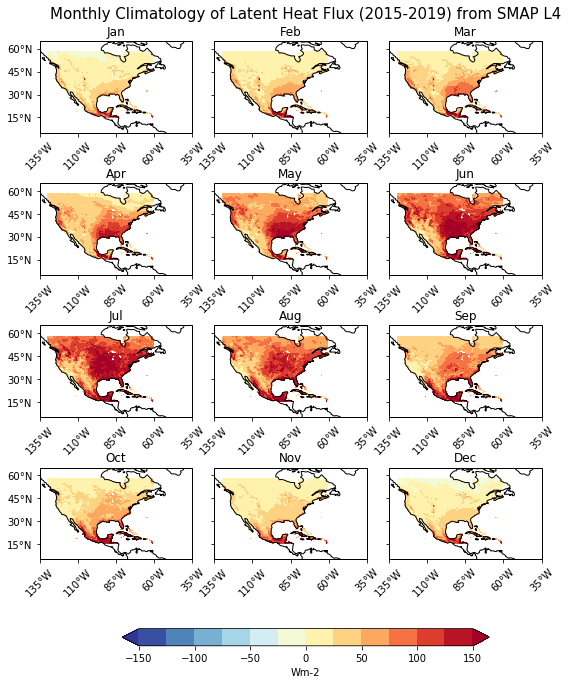

In [12]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
clevs_LH=np.arange(-150,151,25)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], ds2_climo["heat_flux_latent"][i,:,:],
                          clevs_LH, transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of Latent Heat Flux ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_LHF.png')

#### Sensible Heat Flux<a class="anchor" id="SHF"></a>

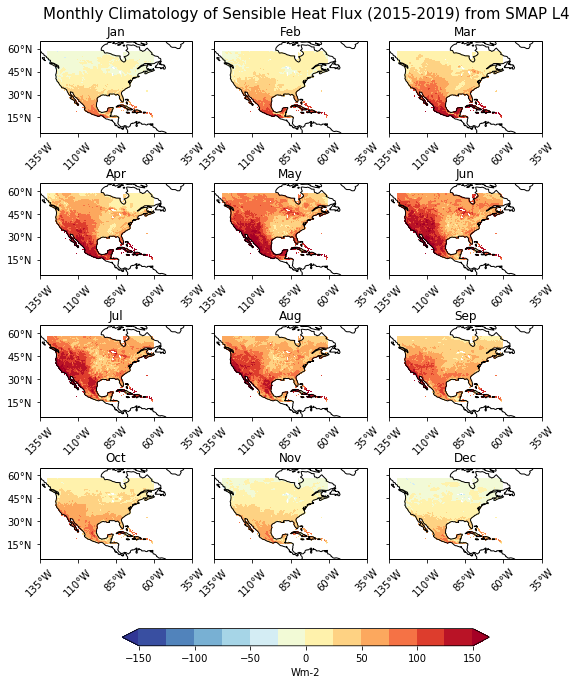

In [13]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
clevs_SH=np.arange(-150,151,25)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], ds2_climo["heat_flux_sensible"][i,:,:],
                          clevs_SH,transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of Sensible Heat Flux ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_SHF.png')

#### Ground Heat Flux<a class="anchor" id="GHF"></a>

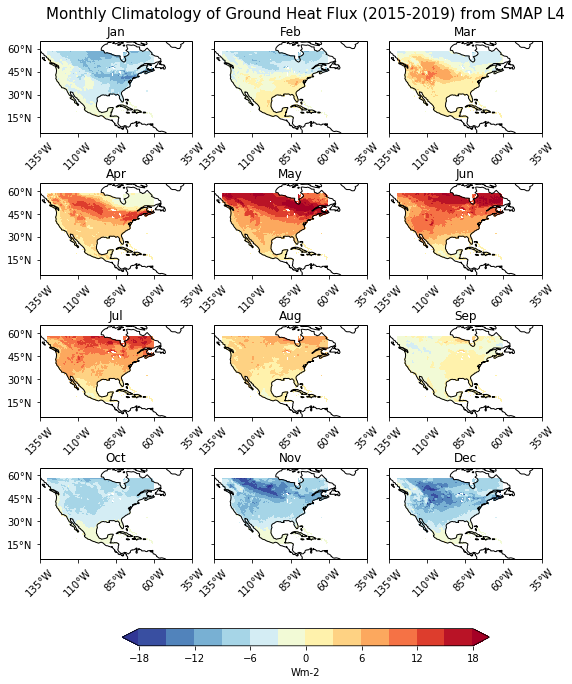

In [16]:
# Define the figure and each axis for the 4 rows and 3 columns
warnings.filterwarnings('ignore')
clevs_GH=np.arange(-18,19,3)

fig, axs = plt.subplots(nrows=4,ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,12), constrained_layout=True, sharey=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()


#Loop over all of the months and plot
for i in list(range(0,12)):
    
        # Contour plot
        cs=axs[i].contourf(ds2_climo["cell_lon"][i,:,:], ds2_climo['cell_lat'][i,:,:], ds2_climo["heat_flux_ground"][i,:,:],
                          clevs_GH, transform = ccrs.PlateCarree(),
                          cmap='RdYlBu_r',extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(calendar.month_abbr[i+1])
        
        # Set extent
        axs[i].set_extent([-135, -35, 5, 65], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-135,-30,25), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Draw the coastines for each subplot
        axs[i].coastlines()
        

# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.3,
                   right=0.9,
                   top=0.9,
                   wspace=0.02,
                   hspace=0.55)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-2')

# Add a big title at the top
start = str(ds2.time.min().values)[0:4]
end = str(ds2.time.max().values)[0:4]
plt.suptitle("Monthly Climatology of Ground Heat Flux ("+start+"-"+end+") from SMAP L4", fontsize=15, y=.94)
plt.savefig('Figs/Climo_GHF.png')

## Assignment Three<a class="anchor" id="AThree"></a>

### Composite Data<a class="anchor" id="Comp"></a>

In [186]:
#Create list of daily files consisting of JJA throughout the available years
ds3_list = glob.glob("/shared/land/SMAP/latest_L4/daily/SMAP_L4_SM_gph_20???[6-8]*.nc4") 

#Sort the files so they are in chronological order 
ds3_list.sort()

#Print out list of file
#ds3_list

In [187]:
#Open all files in list
ds3 = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(600,120, -1), 
                                                                                  x=slice(540,1280))

ds3 #Display xarray of data

<xarray.Dataset>
Dimensions:                            (time: 644, x: 740, y: 480)
Coordinates:
  * y                                  (y) float64 1.905e+06 ... 6.22e+06
  * x                                  (x) float64 -1.25e+07 ... -5.842e+06
  * time                               (time) datetime64[ns] 2015-06-01T01:28:55.816000 ... 2021-08-31T01:28:55.816000
Data variables:
    EASE2_global_projection            (time) |S1 b'' b'' b'' ... b'' b'' b''
    cell_column                        (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lat                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_lon                           (time, y, x) float32 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    cell_row                           (time, y, x) float64 dask.array<chunksize=(1, 480, 740), meta=np.ndarray>
    baseflow_flux                      (time, y, x) float32 dask.array<chunksize=(1, 480

In [188]:
#Open files for regions correspondings with climate classification for composite
#Wm will correspond to the region in the northwest associated with warm temperatures
#Mst will corresond to the region in the southeast associated with moist air
#TrHum = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(600,458,-1),
#                                                                                      x=slice(962,1170))
Mst = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(400,280,-1), 
                                                                                 x=slice(978,1115))
Wm = xr.open_mfdataset(paths=ds3_list, combine='nested', concat_dim='time').isel(y=slice(350,255,-1),
                                                                                 x=slice(695,850))

In [189]:
#Create time average of Latent Heat Flux over US
ds3_tmavg_LHF=ds3['heat_flux_latent'].mean(dim='time').load()

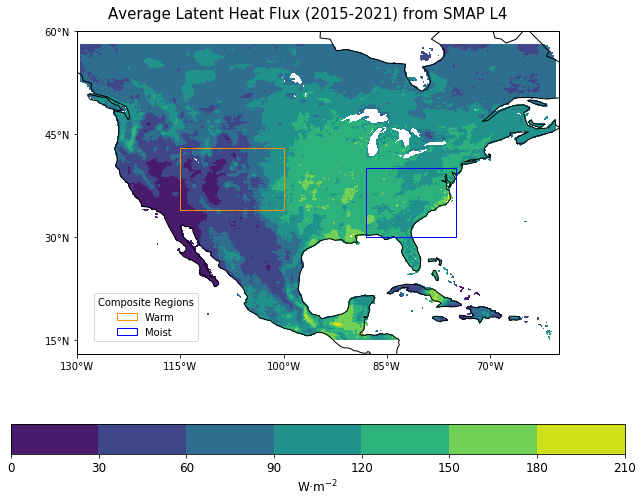

In [195]:
# Set size of image
fig = plt.figure(figsize=(11,8.5))

# Set the axes projection for plot
ax = plt.axes(projection=ccrs.PlateCarree())

# Make a filled contour plot
cs = ax.contourf(ds3['cell_lon'][1,:,:], ds3['cell_lat'][1,:,:], ds3_tmavg_LHF[:,:], transform = ccrs.PlateCarree())

# Add Coastlines
ax.coastlines()

# Set extent
ax.set_extent([-130, -60, 13, 60], crs=ccrs.PlateCarree())
        
# Longitude labels
ax.set_xticks(np.arange(-130,-60,15), crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

# Latitude labels
ax.set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

#Create Color bar
cbar = plt.colorbar(cs, orientation='horizontal', label = 'W m-2')
cbar.set_label(label='W·m$^{-2}$', size='large')
cbar.ax.tick_params(labelsize='large')
plt.suptitle("Average Latent Heat Flux (2015-2021) from SMAP L4", fontsize=15, y=.92)
#plt.savefig('Figs/LandEvap_CartopyContour.png')

#Trop. CLIM Region
#lons_Tr= [-90, -90, -70, -70]
#lats_Tr= [15, 25, 25, 15]
#ring_Tr= LinearRing(list(zip(lons_Tr, lats_Tr)))
#ax.add_geometries([ring_Tr], ccrs.PlateCarree(), facecolor='none', edgecolor='red', linewidth=1)
#plt.text(-90, 25, 'Tropical', horizontalalignment='right', color='red', transform=ccrs.PlateCarree())

#Temp. CLIM Region
lons_Mst= [-88, -88, -75, -75]
lats_Mst= [30, 40, 40, 30]
ring_Mst= LinearRing(list(zip(lons_Mst, lats_Mst)))
ax.add_geometries([ring_Mst], ccrs.PlateCarree(), facecolor='none', edgecolor='blue', linewidth=1)
#plt.text(-78, 35, 'Temperate', horizontalalignment='right', color='red', size=12, transform=ccrs.PlateCarree())

#Dry CLIM Region
lons_Wm= [-115, -115, -100, -100]
lats_Wm= [34, 43, 43, 34]
ring_Wm= LinearRing(list(zip(lons_Wm, lats_Wm)))
ax.add_geometries([ring_Wm], ccrs.PlateCarree(), facecolor='none', edgecolor='darkorange', linewidth=1)
#plt.text(-109, 30, 'Dry', horizontalalignment='right', color='red', size=12, transform=ccrs.PlateCarree())

# make two proxy artists to add to a legend
#trp = mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor="red")
mst = mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor="blue")
wm = mpatches.Rectangle((0, 0), 1, 1, facecolor='none', edgecolor="darkorange")
labels = ['Warm',
              'Moist']
plt.legend([wm, mst], labels,
            loc='lower left', bbox_to_anchor=(0.025, 0.025), title = "Composite Regions",
            fancybox=True)
plt.savefig('Figs/AVG_LHF.png')

In [198]:
#Calculate timeseries data for temperature 
tmp_Wm = (Wm['temp_lowatmmodlay'].mean(dim=('x','y'))).load() # <- Average of temp in Warm Region
hmd_Mst = (Mst['specific_humidity_lowatmmodlay'].mean(dim=('x','y'))).load() # <- Average of humidty in Moist Region

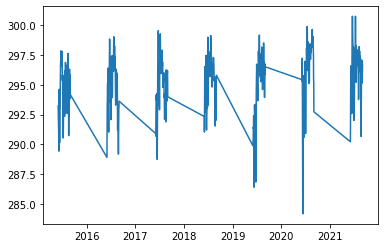

In [199]:
#Look at timeseries for temperature
plt.plot(tmp_Wm['time'], tmp_Wm)

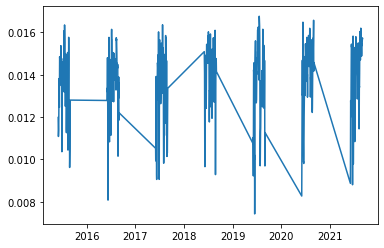

In [200]:
#Look at timeseries for humidity
plt.plot(hmd_Mst['time'], hmd_Mst)

In [ ]:
#Calculate Thresholds for Composite
#Tr_LHF = TrHum['heat_flux_latent'].mean(dim=('time','x', 'y')).load()
#Tm_LHF = Tm['heat_flux_latent'].mean(dim=('time','x', 'y')).load()
#Dr_LHF = Dr['heat_flux_latent'].mean(dim=('time','x', 'y')).load()

#Print threshold values
#print(Tr_LHF)
#print(Tm_LHF)
#print(Dr_LHF)
#print(ds3_avg_LHF)

#### Creating Anomalies and Defining Composite Boundaries

In [217]:
#Create anomolies for index
#Regional temperature average computed above for as 'tmp_Wm'
tmp_climo=(tmp_Wm.groupby('time.month').mean()).load() # <- Calculate monthly mean for temperature in region
tmp_anoms=(tmp_Wm.groupby('time.month')-tmp_climo).load() # <- Subtract monthly means from daily values to obtain anoms
tmp_7d_index=(tmp_anoms.rolling(time=7,center=True).mean().dropna(dim='time')).load() # <- Take mean for every 7 days

In [218]:
#Regional temperature average computed above for as 'tmp_Wm'
hmd_climo=(hmd_Mst.groupby('time.month').mean()).load() # <- Calculate monthly mean for humidity in region
hmd_anoms=(hmd_Mst.groupby('time.month')-hmd_climo).load() # <- Subtract monthly means from daily values to obtain anoms
hmd_7d_index=(hmd_anoms.rolling(time=7,center=True).mean().dropna(dim='time')).load() # <- Take mean for every 7 days

In [211]:
#Temperature
#print(tmp_7d_index # <- Print out index xarray
#print(len(tmp_7d_index)) # <- Print out length of index

#Humidity
print(hmd_7d_index) # <- Print out index xarray
#print(len(hmd_7d_index)) # <- Print out length of index

<xarray.DataArray ()>
array(0.00214317)


In [227]:
#Define temperature boundaries 
top_25t = (tmp_7d_index.where(tmp_7d_index>tmp_7d_index.quantile(.75)))
top_10t = (tmp_7d_index.where(tmp_7d_index>tmp_7d_index.quantile(.90)))

bot_10t = (tmp_7d_index.where(tmp_7d_index<tmp_7d_index.quantile(.10)))
bot_25t = (tmp_7d_index.where(tmp_7d_index<tmp_7d_index.quantile(.25)))

#plt.plot(top_10['time'], top_10)

In [228]:
#Define temperature boundaries 
top_25q = (hmd_7d_index.where(hmd_7d_index>hmd_7d_index.quantile(.75)))
top_10q = (hmd_7d_index.where(hmd_7d_index>hmd_7d_index.quantile(.90)))

bot_10q = (hmd_7d_index.where(hmd_7d_index<hmd_7d_index.quantile(.10)))
bot_25q = (hmd_7d_index.where(hmd_7d_index<hmd_7d_index.quantile(.25)))

#plt.plot(top_10['time'], top_10)

In [230]:
#Compute counts for composite conditions
counts_tmp =[top_25t.count(dim='time').values,
        top_10t.count(dim='time').values,
        bot_10t.count(dim='time').values,
        bot_25t.count(dim='time').values]

counts_hmd =[top_25q.count(dim='time').values,
        top_10q.count(dim='time').values,
        bot_10q.count(dim='time').values,
        bot_25q.count(dim='time').values]

#print(counts_tmp)
#print(counts_hmd)

In [231]:
# Create anomalies for the Latent Heat Flux profile
ET_climo=(ds3['heat_flux_latent'].groupby('time.month').mean(dim='time')).load()
ET_anoms=(ds3['heat_flux_latent'].groupby('time.month')-ET_climo).load()
ET_anoms = (ET_anoms.assign_coords(lon=(ds3['cell_lon']), lat=(ds3['cell_lat']))).load()
#ET_anoms

In [232]:
ET_anoms[:,240,370].mean().values

array(1.8007266e-06, dtype=float32)

### Compose and Map Composite

In [233]:
Wm_Tp_25 = ET_anoms.sel(time=top_25t.dropna(dim='time')['time']).mean(dim='time').load()
Wm_Tp_10 = ET_anoms.sel(time=top_10t.dropna(dim='time')['time']).mean(dim='time').load()
Wm_Bt_10 = ET_anoms.sel(time=bot_10t.dropna(dim='time')['time']).mean(dim='time').load()
Wm_Bt_25 = ET_anoms.sel(time=bot_25t.dropna(dim='time')['time']).mean(dim='time').load()


Hmd_Tp_25 = ET_anoms.sel(time=top_25q.dropna(dim='time')['time']).mean(dim='time').load()
Hmd_Tp_10 = ET_anoms.sel(time=top_10q.dropna(dim='time')['time']).mean(dim='time').load()
Hmd_Bt_10 = ET_anoms.sel(time=bot_10q.dropna(dim='time')['time']).mean(dim='time').load()
Hmd_Bt_25 = ET_anoms.sel(time=bot_25q.dropna(dim='time')['time']).mean(dim='time').load()

In [235]:
#comp_sm=[Tr_sm,Tm_sm,Dr_sm]
comp_ET = [Wm_Tp_25,
           Wm_Tp_10,
           Wm_Bt_10,
           Wm_Bt_25,
           Hmd_Tp_25,
          Hmd_Tp_10,
          Hmd_Bt_10,
          Hmd_Bt_25]
#print(comp_ET)

ValueError: The coordinate must be equally spaced.

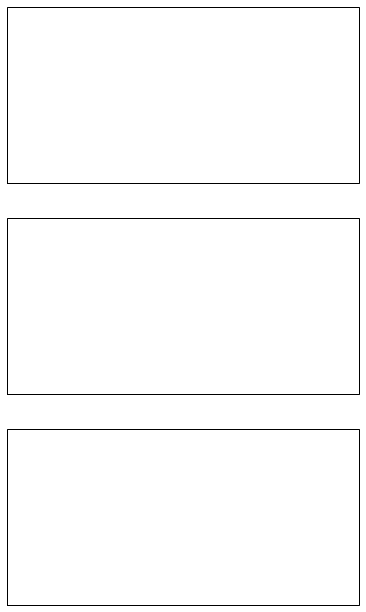

In [180]:
labels=['Tropical','Temperate', 'Dry']
#clevs=np.arange(-0.6,0.7,0.1)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=3,ncols=1,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,11))

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,clim in enumerate(comp_sm):

        # Select the season
        data=comp_sm[i]

        # Add the cyclic point
        data,lons=add_cyclic_point(data,coord=ds3['cell_lon'][1,1,:])

        # Contour plot
        cs=axs[i].contourf(lons,ds3['cell_lat'][1,:,1],data,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')
        
        # Set extent
        axs[i].set_extent([-130, -60, 13, 60], crs=ccrs.PlateCarree())
        
        # Longitude labels
        ax[i].set_xticks(np.arange(-130,-60,15), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,65,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        
        # Title each subplot with the name of the season
        axs[i].set_title(labels[i]+' ('+str(counts[i])+')')

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.2, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='m3/m3')

# Add a big title at the top
plt.suptitle('Composite Soil Moisture Anomalies in different Climate Regimes')

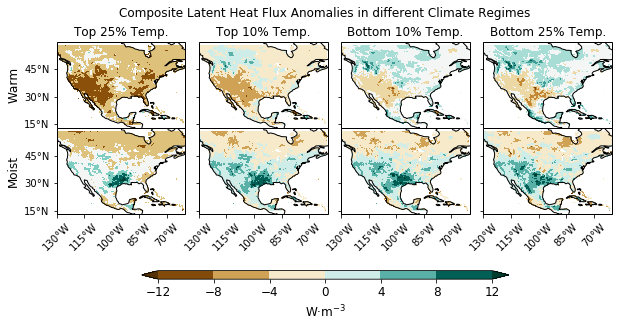

In [298]:
labels=['Top 25% Temp.', 'Top 10% Temp.',
        'Bottom 10% Temp.', 'Bottom 25% Temp.']
#clevs=np.arange(-0.6,0.7,0.1)

# Define the figure and each axis for the 3 rows and 3 columns
fig, axs = plt.subplots(nrows=2,ncols=4,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(8.5,6),sharey=True, sharex=True)

# axs is a 2 dimensional array of `GeoAxes`.  
# We will flatten it into a 1-D array
axs=axs.flatten()

#Loop over all of the seasons and plot
for i,clim in enumerate(comp_sm):

        # Select the season
        data=comp_sm[i]
        
        if (i < 4):

            # Contour plot
            cs=axs[i].contourf(ds3['cell_lon'][1,1,:],ds3['cell_lat'][1,:,1],data,
                            transform = ccrs.PlateCarree(),
                            cmap='BrBG',extend='both')
        
            # Title each subplot with the name of the season
            axs[i].set_title(labels[i])
        else:
            # Contour plot
            cs=axs[i].contourf(ds3['cell_lon'][1,1,:],ds3['cell_lat'][1,:,1],data,
                          transform = ccrs.PlateCarree(),
                          cmap='BrBG',extend='both')
        
        # Set extent
        axs[i].set_extent([-130, -60, 13, 60], crs=ccrs.PlateCarree())
        
        # Longitude labels
        axs[i].set_xticks(np.arange(-130,-60,15), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)
        axs[i].tick_params(axis='x', labelrotation = 45)

        # Latitude labels
        axs[i].set_yticks(np.arange(15,59,15), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)
        
        # Title each subplot with the name of the season
        #axs[i].set_title(labels[i])

        # Draw the coastines for each subplot
        axs[i].coastlines()
        
# Adjust the location of the subplots 
# on the page to make room for the colorbar
fig.subplots_adjust(left=0.05,
                   bottom=0.5,
                   right=0.98,
                   top=0.9,
                    wspace=0,
                    hspace=0)

axs[0].set_ylabel("Warm", size='large')
axs[4].set_ylabel("Moist", size='large')
# Adjust the location of the subplots 
# on the page to make room for the colorbar
#fig.subplots_adjust(bottom=0.25, top=0.9, left=0.05, right=0.95,
#                    wspace=0.1, hspace=0.5)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.2, 0.35, 0.6, 0.02])

# Draw the colorbar
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal',label='Wm-3')
cbar.set_label(label='W·m$^{-3}$', size='large')
cbar.ax.tick_params(labelsize='large')

# Add a big title at the top
plt.suptitle('Composite Latent Heat Flux Anomalies in different Climate Regimes')
plt.savefig('Figs/LHF_Composite.png')

In [328]:
ds3=ds3.resample(time="1MS").mean(dim="time")